# River load sensor calibration with machine learning

![](./images/station-hydrologique-digue.jpeg)
_Station hydrologique du site de la Digue, sur la rivière de Capesterre. © ObsEra_

The original version of this notebook was made by Antoine Lucas on top of the study made by Amande Roque-Bernard with the help of Gregory Sainton. In order to know more about the scientific context, please refer to Roque-Bernard et al. ([2023](https://doi.org/10.5194/esurf-11-363-2023)) "Phenomenological model of suspended sediment transport in a small catchment", Earth Surf. Dynam., 11, 363–381. The dataset comes from the _OBServatoire de l’Eau et de l’éRosion aux Antilles_ ([ObsEra](https://www.ozcar-ri.org/fr/observatoire-obsera/)), an observatory located in Guadeloupe that gives us information on the erosion of this volcanic island in a few watersheds. With this notebook, you will learn how to prepare and clean a dataset.

The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course "Earth Data Science" at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

<img src="images/logo-obsera.png" style="margin:20px; height:100px;"/> <img src="images/logo-ipgp-upc.png" height=100 style="margin:20px; height:100px;"/>

## Instructions

This notebook contains a series of questions to which you should answer. Some example cells are given in the notebook to help you. You should not modify these cells. You can add as many cells as you want to answer the questions. You can also add markdown cells to explain your approach. 
## Prerequisites

Before running the notebook, you should make sure that the necessary packages are installed. You can do this by running the following cell. Be sure you are using a correct environment (check the top right corner of the notebook for the name of the environment). Note that there is a blank line between the first import and the other ones. This is because we follow the [PEP8](https://www.python.org/dev/peps/pep-0008/) convention between standard library imports and third party imports.

In [16]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

## 1. Introduction

Estimating the suspended load within a river is a key issue in geomorphology. The suspended load is often estimated by sampling the water column and measuring the concentration $C_S$ of suspended particles. Although this method is accurate, it is not suitable for long-term monitoring, since it is time-consuming and expensive. A cheaper and faster method is to use turbidity probes. 

Turbidity probes allow to measure the turbidity $T$ of the water column, which is related to the concentration of suspended particles. However, the relationship between turbidity and suspended load is not straightforward. It depends on the size and the shape of the particles. The goal of this notebook is to calibrate a turbidity probe placed in a river against independent measurements of suspended load. In other terms, we want to find a relationship between the turbidity and the suspended load. And for this, we will use a machine-learning approach.

> __Question 1.__ What kind of machine learning problem is this? What is the input $x$, the output $y$? What are the features, the labels, what are the dimensions of the features and the labels spaces? 

The dataset comes from the _OBServatoire de l’Eau et de l’éRosion aux Antilles_ ([ObsERA](https://www.ozcar-ri.org/fr/observatoire-obsera/)), an observatory located in Guadeloupe that gives us information on the erosion of this volcanic island in a few watersheds. With this notebook, you will learn how to prepare and clean a dataset. It is likely the most important part of the job. Then, you will play with your first models with the `scikit-learn` library. 

## 2. Suspended load measurements

The data for the calibration are stored under the [`./data`](./data) directory. The data are separated in two subsets, one with chemical information which contains the independent measurements of suspended load, and another one with hydrological information which contains the turbidity and water level measurements. 

### 2.1. Load the chemical data

The chemical data comes in a single CSV file located under the [`./data/chemistry`](./data/chemistry) repository. We here load it in a Pandas dataframe with the `pd.read_csv()` function. The goal of this first cell is to correctly parse the data, especially by converting the date and time information into `pd.Timestamp` objects and by selecting the column of interest. Note that the last statement of a Jupyter cell is automatically printed.

In [17]:
# Declare the path to the data
filepath = "./data/chemistry/CE_DIG_OBSERA_RIVERS_2019-09-26.csv"

# Read it into a pandas dataframe
data_chemical = pd.read_csv(filepath, delimiter=";")

# Print the first 5 rows
data_chemical.head()

,Date,Hour,Code Site,Site,Level,Type,Flask,Twater (°C),Suspended Load,pH,...,K,Mg,Ca,HCO3,Cl,SO4,Conductivity at 25°C,NICB (%),Comment,Validate
0,2019-09-20,10:53,GRCCEDIG,RCCEDIG,14.0,2,P,23.3,NaN,7.28,...,NaN,NaN,NaN,30.7,NaN,NaN,64.1,NaN,Alc. mesurée en labo le 20/09/2019; autres par...,NaN
1,2019-07-29,12:52,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,118.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.1,NaN,P24,NaN
2,2019-07-28,20:22,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,17.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.7,NaN,P13,NaN
3,2019-07-28,18:51,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,38.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.3,NaN,P12,NaN
4,2019-07-28,18:36,GRCCEDIG,RCCEDIG,NaN,1,P,NaN,48.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.4,NaN,P11,NaN


### 2.2. Turn the index into a datetime index

Note that pandas DataFrames have a special column called the index. This column is used to uniquely identify each row of the DataFrame. By default, the index is a sequence of integers from $0$ to $N-1$, where $N$ is the number of rows in the DataFrame. You can also use the date and time information as the index of the DataFrame. This is useful when you want to select a subset of the data based on date and time information. The following cell shows how to do this.

In [18]:
# Parse the date and time columns into a new column named datetime
date_and_time = data_chemical["Date"] + " " + data_chemical["Hour"]

# Convert the datetime column to datetime object
data_chemical["datetime"] = pd.to_datetime(date_and_time, format="mixed")

# Set the datetime column as the index
# The inplace=True argument tells pandas to replace the existing dataframe
data_chemical.set_index("datetime", inplace=True)
data_chemical.sort_index(inplace=True)

# Drop the old date and time columns
data_chemical.drop(["Date", "Hour"], axis=1, inplace=True)

# Check head
data_chemical.head()

,Code Site,Site,Level,Type,Flask,Twater (°C),Suspended Load,pH,Conductivity,Na,K,Mg,Ca,HCO3,Cl,SO4,Conductivity at 25°C,NICB (%),Comment,Validate
datetime,,,,,,,,,,,,,,,,,,,,
2006-11-09 09:30:00,GRCCEDIG,RCCEDIG,15.0,2,P,22.2,NaN,7.43,NaN,5.2612,0.4442,1.2939,4.8087,25.52,4.9911,2.2282,55.5,-3.200518,NaN,NaN
2006-12-05 10:45:00,GRCCEDIG,RCCEDIG,97.0,2,P,21.4,161.2,6.51,NaN,2.5170,0.3257,0.3962,1.2793,4.94,3.2472,0.9795,22.2,9.945282,NaN,NaN
2006-12-08 10:00:00,GRCCEDIG,RCCEDIG,25.0,2,P,22.2,1.4,7.30,NaN,5.1830,0.5151,1.1061,3.7630,17.18,5.7392,1.8796,62.1,6.733688,NaN,NaN
2006-12-13 09:50:00,GRCCEDIG,RCCEDIG,28.0,2,P,21.5,NaN,7.42,NaN,5.3743,0.5223,1.1815,4.2852,26.79,5.6854,2.1321,49.4,-15.340436,NaN,NaN
2006-12-15 10:20:00,GRCCEDIG,RCCEDIG,64.0,2,P,21.2,NaN,6.82,NaN,3.2850,0.3419,0.5086,1.5788,6.79,4.0292,1.0698,24.2,9.206315,NaN,NaN


### 2.3. Select the suspended load column

Finally, we extract the data of interest here, a.k.a. the suspended load measurements. Note that since this is only a single column from the `data_chemical` DataFrame, the result is a pandas Series.

In [19]:
# Extract the suspended load
suspended_load = data_chemical["Suspended Load"]

# Drop the NaN values
suspended_load.dropna(inplace=True)

# Print the first few rows
suspended_load.head()

datetime
2006-12-05 10:45:00    161.2
2006-12-08 10:00:00      1.4
2007-03-06 09:30:00     19.2
2007-03-07 14:30:00     11.3
2007-03-12 10:30:00     29.2
Name: Suspended Load, dtype: float64

Pandas is a very handy library to inspect and manipulate data. You can find more information about it in the [documentation](https://pandas.pydata.org/pandas-docs/stable/). For instance, some high-level methods allow you to quickly inspect the data. For instance, the `describe()` method gives you a summary of the data. The `plot()` method allows you to quickly plot the data. You can also use the `head()` and `tail()` methods to inspect the first and last rows of the DataFrame. 

> __Question 2.__ Can you give a high-level definition of what an object is in Python? This definition should include the notion of _attributes_ and _methods_. According to this definition, what is a DataFrame, and what does the `info()` instruction do?

count     340.000000
mean      121.640176
std       206.564466
min         0.300000
25%        16.700000
50%        55.750000
75%       147.500000
max      1702.000000
Name: Suspended Load, dtype: float64

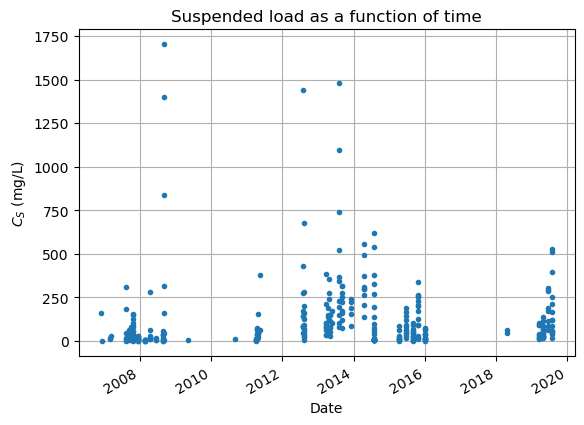

In [20]:
# Plot
suspended_load.plot(
    style=".",
    xlabel="Date",
    ylabel="$C_S$ (mg/L)",
    grid=True,
    title="Suspended load as a function of time",
)

# Describe the data
suspended_load.describe()

## 3. Hydrological data

Your turn now! In this part, we will deal with the hydrological data. The goal is to extract the turbidity data and to compare it with the suspended load data. Note that the hydrological data are split into different files. We will have to merge them into a single DataFrame.

> __Question 3.__ Load the hydrological data into a single DataFrame. You can use the `pd.read_csv()` and the `pd.concat()` functions to read and concatenate the different DataFrames. Similarly to the chemical data, you should use the date and time information as the index of the DataFrame. What relevant information do you think you should extract from the hydrological data to perform the calibration?

In [21]:
# Your amazing code here

## 4. Prepare and inspect the data

### 4.1. Synchronize the data

You may have realized that the chemical and hydrological data are not synchronized. Actually, the chemical data is sparse in time, whereas the hydrological data is (more or less) continuous with a minimum of 1 measurement every 5 minutes. We will have to synchronize the data to be able to compare them.

> __Question 4.__ Resample the hydrological data to match the chemical data. You can use the `pd.DataFrame.resample()` method in order to do this. Take the time to read the documentation of this method, and to see implemented examples on the web.

### 4.2. Inspect the dataset

Now we can start to investigate correlations between the turbidity and the suspended load. We will start by plotting the data. We will also compute the correlation coefficient between the turbidity and the suspended load. The goal here is to get a first idea of the relationship between the turbidity and the suspended load. 

> __Question 5.__ Using the `pd.plotting.scatter_matrix()` function, inspect the relationship between the turbidity, water level and suspended load. What do you observe? Does the correlation coefficient give you a good idea of the relationship between the turbidity and the suspended load? 

## 5. Calibrate the turbidity probe with machine learning

In this section, we will try several machine learning models to find the best one to predict the suspended load from the turbidity. We will use the `scikit-learn` library. 

We first need to formalize the problem we are trying to solve. The goal here is to find the relationship between the turbidity $x$ and the suspended load $y$. In other terms, we want to find a function $f_\theta$ such that 

$$f_\theta(x) = y$$

This function is called a model, and its parameters are noted $\theta$ = $(\theta_1, \theta_2, \dots, \theta_n)$. We will try several models and compare them to find the best one, namely $\theta^*$ = $(\theta_1^*, \theta_2^*, \dots, \theta_n^*)$, that minimizes the error between the predicted suspended load and the measured suspended load.

### 5.1. First naive trial with linear regression

There is no real need to use the `scikit-learn` library to perform a linear regression. However, it is a good way to start to use the library and understand its _greybox_ approach. In the next cell, we will import a linear regression model, instantiate it, fit it to the data and plot the result. Following the notations above, the linear regression uses a model of the form

$$y = f_\theta(x) = \theta_1 x + \theta_0$$

The parameters $\theta_0$ and $\theta_1$ are called the intercept and the slope, respectively. The goal of the linear regression is to find the best values for these parameters. In other terms, we want to find the best line that fits the data.

> __Question 6.__ What is the error function minimized by the linear regression? What score do you obtain out of the linear regression? What does it mean? Do you think that splitting the data into a training and a testing set is useful here?

In [22]:
# Rename vectors
y = np.ones(10)
x = np.zeros(10) # Turn turbidity into a numpy array here

# Reshape the vectors
y = y.reshape(-1, 1)
x = x.reshape(-1, 1)

# Create a linear regression object
model_1 = linear_model.LinearRegression()

# Fit the model
model_1.fit(x, y)

# Get predictions
y_pred = model_1.predict(x)

# Plot results

### 5.2. Robust linear regression

It is obvious that the linear regression struggles with outliers. Several solutions exist to deal with outliers. One of them is to use a robust linear regression, which performs the linear regression on a subset of the data and iteratively removes the outliers in a randomized way. The `scikit-learn` library provides a robust linear regression model. You can find more information about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).

> __Question 7.__ Use the robust linear regression model to fit the data. What score do you obtain? How does it depend on the hyperparameters of the model? Do you think that splitting the data into a training and a testing set is useful here?

### 5.3. Working in the log-log space

As you were told quite a lot in the lecture, the representation of the data is very important. As you can understand from the scatter matrix plot that we did in the data preparation section, the density of measurements in higher for lower values of the suspended load. This is a problem for the linear regression, since it will tend to fit the data in the low range of suspended load. One way to deal with this problem is to work in the log-log space.

> __Question 8.__ Make the inspection of the data in the log-log space. What do you observe? What is the score of the linear regression in the log-log space? What is the score of the robust linear regression in the log-log space? 

### 5.4. Using a multivariate linear regression

We have seen that the water level is also correlated with the suspended load. It is therefore interesting to use it as an additional feature to predict the suspended load. This is called a multivariate linear regression. The `scikit-learn` library provides a multivariate linear regression model. You can find more information about it in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

> __Question 9.__ Use the multivariate linear regression model to fit the data. What score do you obtain? How does it depend on the hyperparameters of the model? 

### 5.5. Testing other models

Now we can use the `scikit-learn` library to test other models. You can find a list of the available models in the [documentation](https://scikit-learn.org/stable/supervised_learning.html). You can also find a list of the available metrics in the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). This is a good opportunity to understand the concept of greybox. You can also use the `scikit-learn` [cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help you choose the right model.

![](https://scikit-learn.org/stable/_static/ml_map.png)

> __Question 10.__ Test other models and compare them. What is the best model? Consider using a train-test split to answer this question. 